In [ ]:
import time
import datetime
import numpy as np
import pandas as pd 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")

matplotlib.style.use('ggplot')
%matplotlib inline

In [ ]:
new_train = pd.read_csv('../input/shift-cft-new-train-dataset/new_train.csv')
new_test = pd.read_csv('../input/shift-cft-new-test-dataset/shift-cft-new-test-dataset.csv')

In [ ]:
X_train = new_train.copy()
y_train = new_train["target"]

X_test = new_test.copy()

X_train.head()

,id,target,big station,small station,bus stop,hospital,pharmacy,theatre,cinema,park,...,bar,store,bank,atm,chrisians,muslims,police,fire station,school,kindergarten
0,0.0,1.0,3.0,0.0,20.0,6.0,0.0,2.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,3.0
1,1.0,1.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0
2,2.0,1.0,4.0,2.0,10.0,1.0,0.0,0.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,4.0
3,3.0,1.0,2.0,1.0,2.0,5.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,1.0
4,4.0,0.0,0.0,0.0,6.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0


Заменим пропуски, если таковые имеются, на нули

In [ ]:
X_train = X_train.fillna(value=0)
y_train = y_train.fillna(value=0)

X_test = X_test.fillna(value=0)

**Количество автобусных остановок**

In [ ]:
data1 = X_train.copy()

print("В среднем в двух километрах от клиента находится {:.4f} автобусных остановок, в 99% случаев {} автобусных остановок и меньше, а наибольшее количество остановок составляет {}.".format(data1['bus stop'].mean(), data1['bus stop'].quantile(0.99), data1['bus stop'].max()))

В среднем в двух километрах от клиента находится 8.4166 автобусных остановок, в 99% случаев 24.01000000000022 автобусных остановок и меньше, а наибольшее количество остановок составляет 35.0.


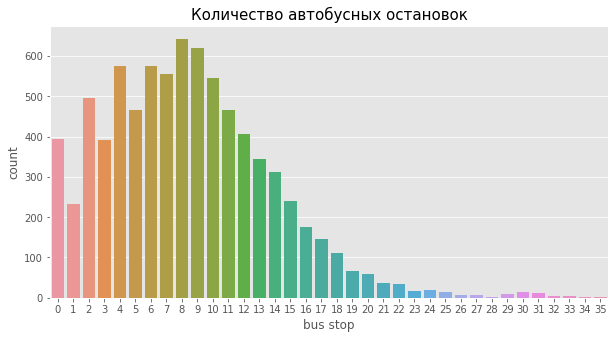

In [ ]:
data = data1.copy()
plt.figure(figsize=(10,5))
sns.countplot(data['bus stop'].astype('int').sort_values())
plt.title("Количество автобусных остановок",fontsize=15)
plt.show()

Построим графики зависимости хорошего исхода от количества автобусных остановок

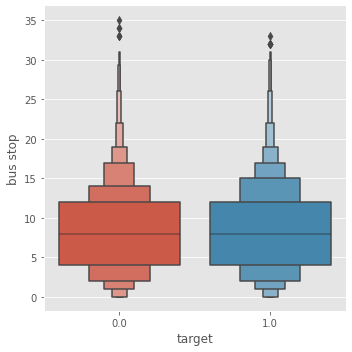

In [ ]:
sns.catplot(x='target', y='bus stop', kind='boxen', data=data1)
plt.show()

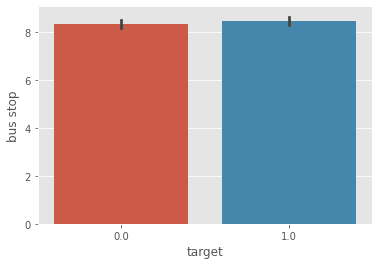

In [ ]:
sns.barplot(x='target', y='bus stop', data=data1)
plt.show()

Видим, что хороший исход не зависит от количества автобусных остановок

**Количество школ**

In [ ]:
data1 = X_train.copy()

print("В среднем количество школ составляет {:.4f}, в 99% случаев клиент живёт рядом {} с школами и меньше, а наибольшее количество школ составляет {}.".format(data1['school'].mean(), data1['school'].quantile(0.99), data1['school'].max()))

В среднем количество школ составляет 2.0964, в 99% случаев клиент живёт рядом 7.0 с школами и меньше, а наибольшее количество школ составляет 12.0.


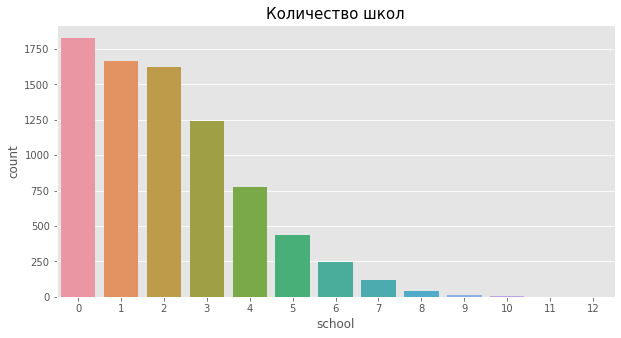

In [ ]:
data = data1.copy()
plt.figure(figsize=(10,5))
sns.countplot(data['school'].astype('int').sort_values())
plt.title("Количество школ",fontsize=15)
plt.show()

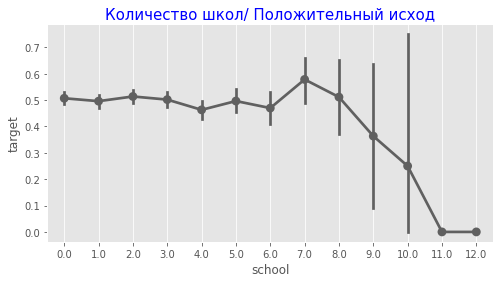

In [ ]:
f,ax1 = plt.subplots(figsize =(8,4))
sns.pointplot(x='school', y='target', data=data1, color='#606060', alpha=0.8)
plt.title('Количество школ/ Положительный исход',fontsize = 15,color='blue')
plt.grid()
plt.show()

Видно, что есть небольшая зависимость между количеством школ и хорошим исходом

**Построим корреляционную матрицу**

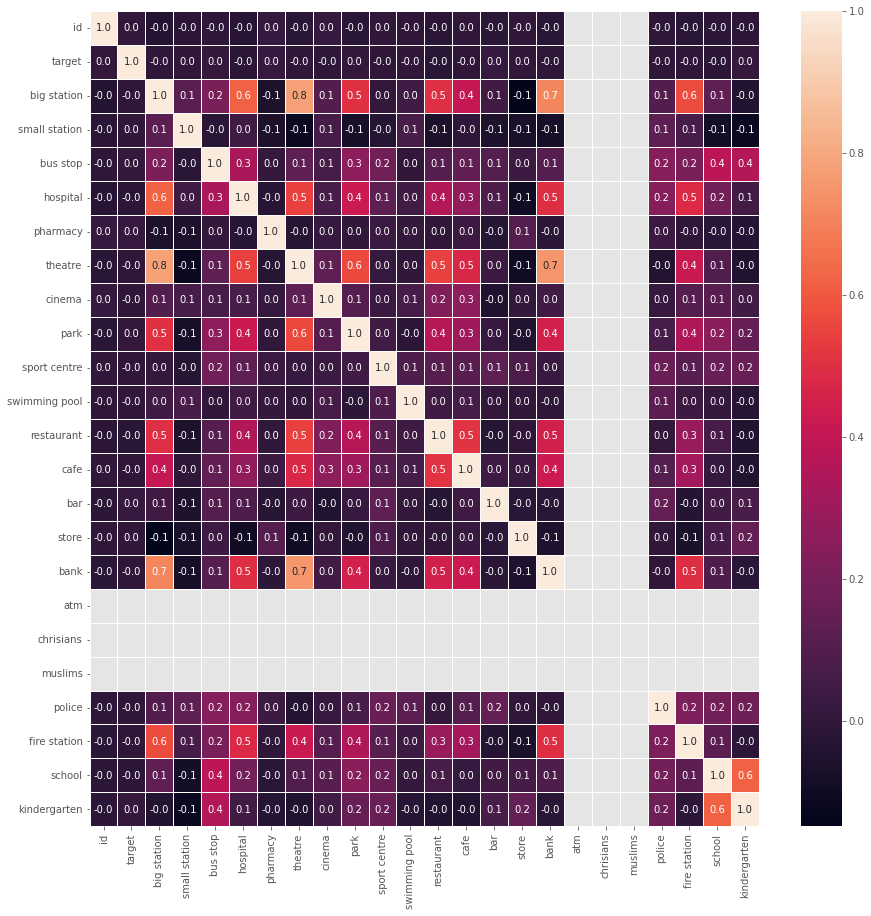

In [ ]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(X_train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

Видно, что некоторые признаки между собой коррелируют, например театр и вокзал или банк и вокзал.
А также замечаем, что у столбцов atm, chrisians, muslims все значения нулевые.

Давайте увеличим масштаб до топ-5 наиболее положительно коррелирующих переменных с целевой переменной.

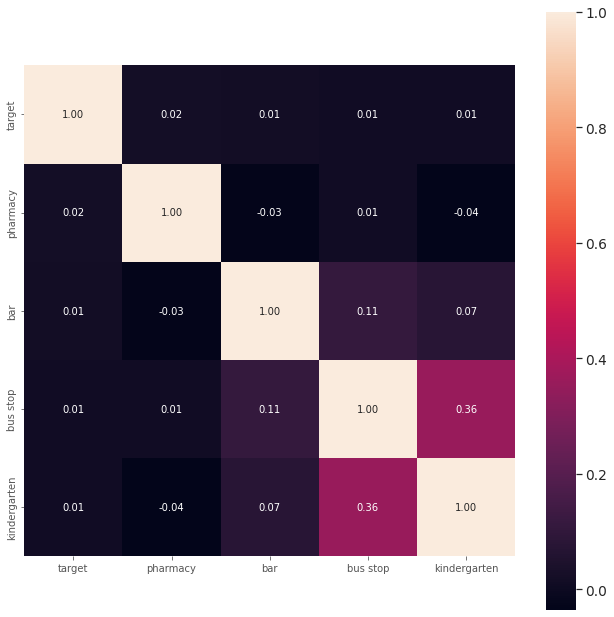

In [ ]:
k = 5 #количество переменных для тепловой карты
f,ax = plt.subplots(figsize=(11, 11))
cols = X_train.corr().nlargest(k, 'target')['target'].index
cm = np.corrcoef(X_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

**Количество аптек**

In [ ]:
data1 = X_train.copy()

print("В среднем количество аптек составляет {:.1f}, 99% процентов клиентов имеют {} или меньше аптек недалеко от своего дома, самое большое количетво аптек составляет {}.".format(data1['pharmacy'].mean(), data1['pharmacy'].quantile(0.99), data1['pharmacy'].max()))

В среднем количество аптек составляет 0.0, 99% процентов клиентов имеют 1.0 или меньше аптек недалеко от своего дома, самое большое количетво аптек составляет 2.0.


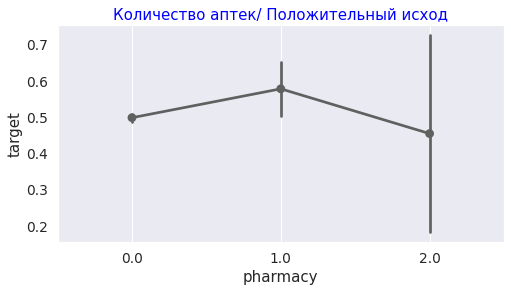

In [ ]:
f,ax1 = plt.subplots(figsize =(8,4))
sns.pointplot(x='pharmacy', y='target', data=data1, color='#606060', alpha=0.8)
plt.title('Количество аптек/ Положительный исход',fontsize = 15,color='blue')
plt.grid()
plt.show()

In [ ]:
X_train = X_train.loc[:, X_train.columns!="target"]

**Обучим логистическую регрессию**

Проведём кросс-валидацию для логистической регрессии с подбором лучшего параметра регуляризации и поссчитаем качество

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

In [ ]:
def log_reg(X, y):
  scores = {}

  for i in range(-5, 6):
    c = 10.0 ** i
    print('С=', c)
    clf = LogisticRegression(C=c, random_state=42)

    start_time = datetime.datetime.now()
    score = cross_val_score(clf, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
    print('Score:', score)
    print('Time elapsed:', datetime.datetime.now() - start_time)

    scores[i] = score
    print()
  
  return scores

def find_best_c(scores):
  scores = pd.Series(scores)
  best_c = 10.0 ** (scores.sort_values(ascending=False).head(1)).index[0]
  best_score = (scores.sort_values(ascending=False).head(1)).values[0]
  print('Лучший параметр регуляризации равен С =', best_c, ', при котором качество равно', best_score)

С= 1e-05
Score: 0.4976626626456889
Time elapsed: 0:00:02.633688

С= 0.0001
Score: 0.4982566661768756
Time elapsed: 0:00:00.166092

С= 0.001
Score: 0.49971630091087427
Time elapsed: 0:00:00.161603

С= 0.01
Score: 0.5019960175881533
Time elapsed: 0:00:00.167136

С= 0.1
Score: 0.5021574627704914
Time elapsed: 0:00:00.172952

С= 1.0
Score: 0.5021877769582128
Time elapsed: 0:00:00.167598

С= 10.0
Score: 0.5021902819761107
Time elapsed: 0:00:00.169523

С= 100.0
Score: 0.5021912201382408
Time elapsed: 0:00:00.179513

С= 1000.0
Score: 0.5021915333205065
Time elapsed: 0:00:00.178771

С= 10000.0
Score: 0.5021915333205065
Time elapsed: 0:00:00.173436

С= 100000.0
Score: 0.5021915333205065
Time elapsed: 0:00:00.178985



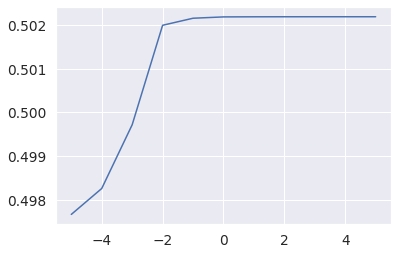

In [ ]:
scores = log_reg(X_train, y_train)
pd.Series(scores).plot()
plt.show()

In [ ]:
find_best_c(scores)

Лучший параметр регуляризации равен С = 1000.0 , при котором качество равно 0.5021915333205065


In [ ]:
X_train_old = X_train.copy()
y_train_old = y_train.copy()

X_test_old = X_test.copy()

**Попробуем XGBoost**

In [ ]:
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.35, random_state=143)

In [ ]:
# Create the XGB classifier, xgb_model.
xgb_model = XGBClassifier(use_label_encoder=False, n_jobs=1)

In [ ]:
# List the default parameters.
print(xgb_model.get_xgb_params())

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'gamma': None, 'gpu_id': None, 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'monotone_constraints': None, 'n_jobs': 1, 'num_parallel_tree': None, 'predictor': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [ ]:
# Train and evaluate.
xgb_model.fit(X_train, y_train, eval_metric=['error'], eval_set=[((X_train, y_train)),(X_test, y_test)])

[0]	validation_0-error:0.46250	validation_1-error:0.49179
[1]	validation_0-error:0.41885	validation_1-error:0.49357
[2]	validation_0-error:0.39385	validation_1-error:0.48607
[3]	validation_0-error:0.37846	validation_1-error:0.48750
[4]	validation_0-error:0.37173	validation_1-error:0.48607
[5]	validation_0-error:0.36250	validation_1-error:0.47964
[6]	validation_0-error:0.35231	validation_1-error:0.48179
[7]	validation_0-error:0.34827	validation_1-error:0.48036
[8]	validation_0-error:0.33904	validation_1-error:0.47679
[9]	validation_0-error:0.32500	validation_1-error:0.47250
[10]	validation_0-error:0.31539	validation_1-error:0.47143
[11]	validation_0-error:0.31231	validation_1-error:0.46929
[12]	validation_0-error:0.30058	validation_1-error:0.48071
[13]	validation_0-error:0.29558	validation_1-error:0.47893
[14]	validation_0-error:0.28385	validation_1-error:0.47679
[15]	validation_0-error:0.28212	validation_1-error:0.47714
[16]	validation_0-error:0.27538	validation_1-error:0.47286
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [ ]:
from matplotlib import pyplot

%matplotlib inline

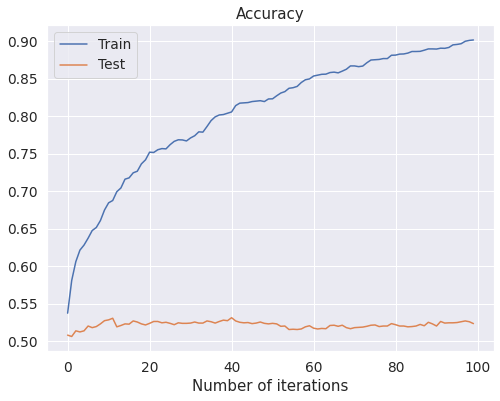

In [ ]:
# Plot and display the performance evaluation
xgb_eval = xgb_model.evals_result()
eval_steps = range(len(xgb_eval['validation_0']['error']))

fig, ax = pyplot.subplots(1, 1, sharex=True, figsize=(8, 6))

ax.plot(eval_steps, [1-x for x in xgb_eval['validation_0']['error']], label='Train')
ax.plot(eval_steps, [1-x for x in xgb_eval['validation_1']['error']], label='Test')
ax.legend()
ax.set_title('Accuracy')
ax.set_xlabel('Number of iterations');

In [ ]:
# Select trained model.
n_trees = 40
y_pred = xgb_model.predict(X_test, ntree_limit= n_trees)

In [ ]:
# Check the accuracy of the trained model.
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: %.1f%%" % (accuracy * 100.0))

Accuracy: 52.8%


следующий шаг

In [ ]:
xgb_model_gs = XGBClassifier(eval_metric=['error'], use_label_encoder=False, n_jobs=-1)
parameters = {'reg_alpha': [0.0, 1.0], 'reg_lambda': [0.0, 1.0], 'n_estimators': [n_trees], 'seed': [1337]}

In [ ]:
# Search for the best parameters.
clf = GridSearchCV(xgb_model_gs, parameters, scoring='accuracy', cv=5, verbose=-1, n_jobs=-1, refit=True)
clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.4min finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric=['error'], gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, mono...
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                               

In [ ]:
print("Best score: %.1f%%" % (clf.best_score_*100))
print("Best parameter set: %s" % (clf.best_params_))

Best score: 52.9%
Best parameter set: {'n_estimators': 40, 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'seed': 1337}


In [ ]:
y_pred = clf.best_estimator_.predict(X_test, ntree_limit= n_trees)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.1f%%" % (accuracy * 100.0))

Accuracy: 52.8%


проверка на тестовой выборке

In [ ]:
X_test_old_1 = X_test_old.copy()
X_test_old_1.head()

,Unnamed: 0,id,big station,small station,bus stop,hospital,pharmacy,theatre,cinema,park,...,bar,store,bank,atm,chrisians,muslims,police,fire station,school,kindergarten
0,0,8000.0,11.0,0.0,17.0,7.0,0.0,1.0,0.0,4.0,...,0.0,0.0,2.0,0.0,0.0,0.0,2.0,3.0,3.0,1.0
1,1,8001.0,7.0,3.0,20.0,4.0,0.0,2.0,0.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0
2,2,8002.0,2.0,1.0,14.0,2.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,5.0,5.0
3,3,8003.0,14.0,2.0,6.0,10.0,0.0,13.0,0.0,3.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,2.0,4.0,3.0
4,4,8004.0,5.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0


In [ ]:
X_test_old_2 = X_test_old_1.drop(X_test_old_1.columns[[0]], axis = 1)

X_test_old_2['id'] = X_test_old_2['id'].astype(int)
X_test_old_2

,id,big station,small station,bus stop,hospital,pharmacy,theatre,cinema,park,sport centre,...,bar,store,bank,atm,chrisians,muslims,police,fire station,school,kindergarten
0,8000,11.0,0.0,17.0,7.0,0.0,1.0,0.0,4.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,2.0,3.0,3.0,1.0
1,8001,7.0,3.0,20.0,4.0,0.0,2.0,0.0,2.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0
2,8002,2.0,1.0,14.0,2.0,0.0,0.0,0.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,5.0,5.0
3,8003,14.0,2.0,6.0,10.0,0.0,13.0,0.0,3.0,2.0,...,0.0,0.0,5.0,0.0,0.0,0.0,0.0,2.0,4.0,3.0
4,8004,5.0,0.0,9.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,11995,4.0,1.0,15.0,2.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,3.0
3996,11996,4.0,1.0,9.0,3.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0
3997,11997,2.0,2.0,9.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0
3998,11998,5.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0


In [ ]:
y_pred = clf.best_estimator_.predict(X_test_old_2, ntree_limit= n_trees)

In [ ]:
y_pred = pd.DataFrame(y_pred, columns=['target'])
ID_y = [i for i in range(8000, 12000)]
y_pred['ID'] = ID_y

y_pred = y_pred[['ID', 'target']]
y_pred

,ID,target
0,8000,1
1,8001,0
2,8002,1
3,8003,1
4,8004,1
...,...,...
3995,11995,1
3996,11996,1
3997,11997,1
3998,11998,1


In [ ]:
y_pred.to_csv('submission.csv', index=False)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
clf = GradientBoostingClassifier(n_estimators=10000, learning_rate=0.1, max_depth=6, random_state=143).fit(X_train, y_train)
clf.score(X_test, y_test)

0.5253571428571429

In [ ]:
y_pred = clf.predict(X_test_old_2)

In [ ]:
y_pred = pd.DataFrame(y_pred, columns=['target'])
ID_y = [i for i in range(8000, 12000)]
y_pred['ID'] = ID_y

y_pred = y_pred[['ID', 'target']]
y_pred

,ID,target
0,8000,0.0
1,8001,0.0
2,8002,0.0
3,8003,1.0
4,8004,1.0
...,...,...
3995,11995,1.0
3996,11996,0.0
3997,11997,0.0
3998,11998,1.0


In [ ]:
y_pred.to_csv('submission.csv', index=False)